# Домашнее задание: модели классификации и оценка их качества.

Бадаева Санчир, БЭК182

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

A. Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [622]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [623]:
data = pd.read_csv('telecom_churn.csv')

In [624]:
data

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [625]:
X = data.iloc[:,:-1]

y = data['Churn']

In [626]:
p1_num_cols = X.columns[X.dtypes == 'int64'].tolist()
p2_num_cols = X.columns[X.dtypes == 'float64'].tolist()
num_cols = p1_num_cols + p2_num_cols
num_cols.remove('Area code')

cat_cols = X.columns[X.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 15 numeric columns: Account length, Number vmail messages, Total day calls, Total eve calls, Total night calls, Total intl calls, Customer service calls, Total day minutes, Total day charge, Total eve minutes, Total eve charge, Total night minutes, Total night charge, Total intl minutes, Total intl charge
And 3 categorical columns: State, International plan, Voice mail plan


Area code тоже категориальный признак. 

In [627]:
binary_cols = cat_cols[X[cat_cols].nunique() == 2].tolist()
ordinal_cols = ['State', 'Area code']
cat_cols = cat_cols.difference(binary_cols + ordinal_cols).tolist()

In [628]:
print('Num_cols:', num_cols)
print('Binary_cols:', binary_cols)
print('Ordinal_cols:', ordinal_cols)

Num_cols: ['Account length', 'Number vmail messages', 'Total day calls', 'Total eve calls', 'Total night calls', 'Total intl calls', 'Customer service calls', 'Total day minutes', 'Total day charge', 'Total eve minutes', 'Total eve charge', 'Total night minutes', 'Total night charge', 'Total intl minutes', 'Total intl charge']
Binary_cols: ['International plan', 'Voice mail plan']
Ordinal_cols: ['State', 'Area code']


In [631]:
y = (y == True).astype(int)
y

0       0
1       0
2       0
3       0
4       0
       ..
3328    0
3329    0
3330    0
3331    0
3332    0
Name: Churn, Length: 3333, dtype: int64

In [633]:
y.value_counts(normalize=True)

0    0.855086
1    0.144914
Name: Churn, dtype: float64

In [634]:
ord_enc = OrdinalEncoder(cols=ordinal_cols)
X = ord_enc.fit_transform(X)

In [635]:
class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [636]:
cs = CustomScaler(num_cols)
X = cs.fit_transform(X)

In [637]:
X['International plan'].replace({"Yes": 1, "No": 0}, inplace=True)
X['Voice mail plan'].replace({"Yes": 1, "No": 0}, inplace=True)

In [638]:
X

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,1,0.676489,1,0,1,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932
1,2,0.149065,1,0,1,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932
2,3,0.902529,1,0,0,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218
3,2,-0.428590,2,1,0,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354
4,4,-0.654629,1,1,0,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,21,2.283878,1,0,1,2.038605,-0.432895,-1.167924,-0.433386,0.286348,1.299506,0.286880,1.547039,-0.874374,1.547188,-0.120832,0.617898,-0.125496,0.332354
3329,9,-0.830437,1,0,0,-0.591760,0.942447,-2.164631,0.942714,-0.938353,-2.264816,-0.938172,-0.189297,1.170023,-0.188670,-0.228304,-0.194831,-0.231645,1.092641
3330,11,-1.835055,3,0,0,-0.591760,0.018820,0.426808,0.019193,1.731930,-2.114211,1.732349,-0.177431,-0.465494,-0.175486,1.383778,0.617898,1.387123,0.332354
3331,50,2.082955,3,1,0,-0.591760,0.624778,0.227466,0.625153,-0.816080,-0.808966,-0.815203,-1.219628,1.885562,-1.221396,-1.876211,2.243356,-1.876950,0.332354


## A

In [639]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)

grid.fit(X, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8637883760822291
best params: {'C': 0.30000000000000004}


In [640]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

### accuracy

In [641]:
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.30000000000000004)
model.fit(Xtrain, ytrain)

pred_train = model.predict(Xtrain)
pred_test = model.predict(Xtest)

accuracy_score(ytrain, pred_train), accuracy_score(ytest, pred_test)

(0.8705529361337334, 0.849)

### f1

In [642]:
f1_score(ytrain, pred_train), f1_score(ytest, pred_test)

(0.33480176211453744, 0.24875621890547267)

### ROC-AUC

In [643]:
tpr, fpr, _ = roc_curve(ytrain, model.predict_proba(Xtrain)[:, 0])

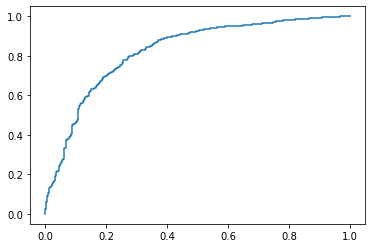

In [644]:
plt.plot(fpr, tpr)

In [645]:
auc(fpr, tpr)

0.8248195179518674

Переобучение есть, так как train > test, но разница мала. Качество неплохое, учитывая, что максимальные значения accuracy и AUC = 1. 

## B

In [688]:
grid = {"C": np.arange(0.1, 1.1, 0.1)}
svm = SVC(kernel='linear') 
svm_cv = GridSearchCV(svm,
                      grid)
svm_cv.fit(X, y)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [689]:
print('best score:', svm_cv.best_score_)
print('best params:', svm_cv.best_params_)

best score: 0.8550859705282494
best params: {'C': 0.1}


### accuracy

In [647]:
svm = SVC(C = 0.1, kernel='linear', probability=True)
svm.fit(Xtrain, ytrain)

pred_train_svm = svm.predict(Xtrain)
pred_test_svm = svm.predict(Xtest)

accuracy_score(ytrain, pred_train_svm), accuracy_score(ytest, pred_test_svm)

(0.8576939562794685, 0.849)

### f1

In [648]:
f1_score(ytrain, pred_train_svm), f1_score(ytest, pred_test_svm)

(0.0, 0.0)

### ROC-AUC

In [649]:
tpr, fpr, _ = roc_curve(ytrain, svm.predict_proba(Xtrain)[:, 0])

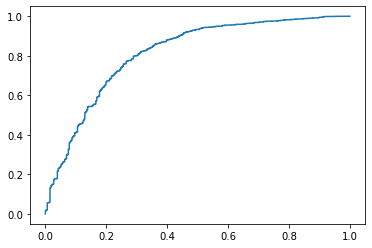

In [650]:
plt.plot(fpr, tpr)

In [651]:
auc(fpr, tpr)

0.8132786016630239

Аналогично модели А. 

## C

In [652]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('logit', LogisticRegression())])

In [653]:
params = {'logit__C': np.arange(0.1, 1.1, 0.1)}
grid = GridSearchCV(logit_pipe, params, cv=3)

grid.fit(X, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8931893189318932
best params: {'logit__C': 0.7000000000000001}


### accuracy

In [658]:
logit_pipe_fin = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('logit', LogisticRegression(C=0.7000000000000001))])

logit_pipe_fin.fit(Xtrain, ytrain)

pred_train_pipe = logit_pipe_fin.predict(Xtrain)
pred_test_pipe = logit_pipe_fin.predict(Xtest)

accuracy_score(ytrain, pred_train_pipe), accuracy_score(ytest, pred_test_pipe)

(0.9039862837548222, 0.882)

### f1

In [659]:
f1_score(ytrain, pred_train_pipe), f1_score(ytest, pred_test_pipe)

(0.6097560975609756, 0.528)

### ROC-AUC

In [660]:
tpr, fpr, _ = roc_curve(ytrain, logit_pipe_fin.predict_proba(Xtrain)[:, 0])

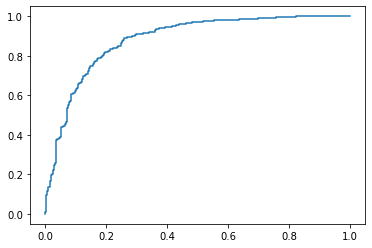

In [661]:
plt.plot(fpr, tpr)

In [662]:
auc(fpr, tpr)

0.8819460751551935

Переобучение снова есть, но разница незначительна. Модель показала наилучшее качество  

## D

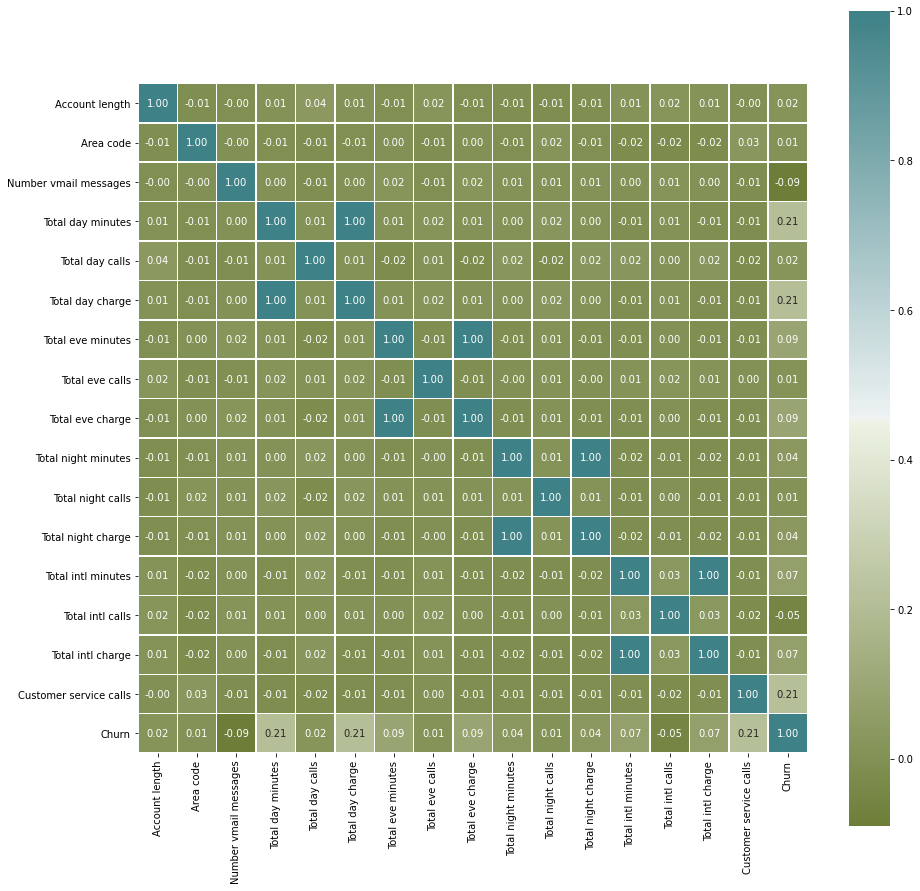

In [663]:
plt.figure(figsize=(15,15))
corr = data.corr()
sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.2f',mask=np.zeros_like(corr, dtype=np.bool), \
            cmap=sns.diverging_palette(100,200, as_cmap=True), square=True)
plt.show()

Не коррелируют с целевой: 
1. Account Length
2. Area Code
3. Number Vmail Messages
4. Total Day Calls
5. Total Eve Minutes 
6. Total Eve Calls
7. Total Eve Charge
8. Total Night Minutes
9. Total Night Calls
10. Total Night Charge
11. Total Intl Minutes
12. Total Intl Calls
13. Total Intl Charge 

Остались только 3 переменные:
1. Total Day Minutes
2. Total Day Charge
3. Customer Service Calls

Из них между собой коррелируют Total Day Minutes и Total Day Charge. Оставляем только Total Day Minutes. В итоге имеем 2 переменные: Total Day Minutes и Customer Service Calls.

In [675]:
X

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,1,0.676489,1,0,1,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932
1,2,0.149065,1,0,1,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932
2,3,0.902529,1,0,0,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218
3,2,-0.428590,2,1,0,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354
4,4,-0.654629,1,1,0,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,21,2.283878,1,0,1,2.038605,-0.432895,-1.167924,-0.433386,0.286348,1.299506,0.286880,1.547039,-0.874374,1.547188,-0.120832,0.617898,-0.125496,0.332354
3329,9,-0.830437,1,0,0,-0.591760,0.942447,-2.164631,0.942714,-0.938353,-2.264816,-0.938172,-0.189297,1.170023,-0.188670,-0.228304,-0.194831,-0.231645,1.092641
3330,11,-1.835055,3,0,0,-0.591760,0.018820,0.426808,0.019193,1.731930,-2.114211,1.732349,-0.177431,-0.465494,-0.175486,1.383778,0.617898,1.387123,0.332354
3331,50,2.082955,3,1,0,-0.591760,0.624778,0.227466,0.625153,-0.816080,-0.808966,-0.815203,-1.219628,1.885562,-1.221396,-1.876211,2.243356,-1.876950,0.332354


In [676]:
X2 = X[["Total day minutes", "Customer service calls"]]
X2

,Total day minutes,Customer service calls
0,1.566767,-0.427932
1,-0.333738,-0.427932
2,1.168304,-1.188218
3,2.196596,0.332354
4,-0.240090,1.092641
...,...,...
3328,-0.432895,0.332354
3329,0.942447,1.092641
3330,0.018820,0.332354
3331,0.624778,0.332354


In [677]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)

grid.fit(X2, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.854185970078024
best params: {'C': 0.1}


In [678]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y, test_size=0.3)

### accuracy

In [679]:
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.1)
model.fit(Xtrain2, ytrain2)

pred_train_lol = model.predict(Xtrain2)
pred_test_lol = model.predict(Xtest2)

accuracy_score(ytrain2, pred_train_lol), accuracy_score(ytest2, pred_test_lol)

(0.8529789969995714, 0.86)

### f1

In [680]:
f1_score(ytrain2, pred_train_lol), f1_score(ytest2, pred_test_lol)

(0.08533333333333333, 0.05405405405405405)

### ROC-AUC

In [681]:
tpr, fpr, _ = roc_curve(ytrain2, model.predict_proba(Xtrain2)[:, 0])

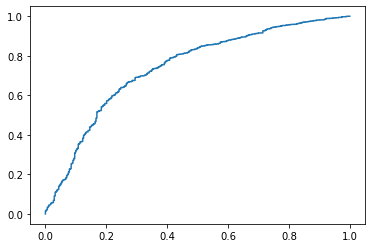

In [682]:
plt.plot(fpr, tpr)

In [683]:
auc(fpr, tpr)

0.7412939332229662

Переобучения нет, но модель оказалась хуже остальных. AUC < 0.8

## E

In [686]:
results = pd.DataFrame({'model': ['A', 'B', 'C', 'D'], 
                        'accuracy_train': [0.8705529361337334, 0.8576939562794685, 0.9039862837548222, 0.8529789969995714], 
                        'accuracy_test': [0.849, 0.849, 0.882, 0.86],
                        'f1_train': [0.33480176211453744, 0, 0.6097560975609756, 0.08533333333333333],
                        'f1_test': [0.24875621890547267, 0, 0.528, 0.05405405405405405],
                        'AUC': [0.8248195179518674, 0.8132786016630239, 0.8819460751551935, 0.7412939332229662]})

In [687]:
results

,model,accuracy_train,accuracy_test,f1_train,f1_test,AUC
0,A,0.870553,0.849,0.334802,0.248756,0.824820
1,B,0.857694,0.849,0.000000,0.000000,0.813279
2,C,0.903986,0.882,0.609756,0.528000,0.881946
3,D,0.852979,0.860,0.085333,0.054054,0.741294


а) C-модель показала наилучшие результаты: максимальные accuracy_test, f1_test и AUC. 

b) В С были добавлены полиномиальные признаки, а в D - подробнее расписано в соответствующем пункте задачи. 

c) Ну, в моделях A, B и C имеет место переобучение, так как train > test, но разница совсем маленькая. В D переобучения нет. 

## Часть 2. Оценка качества моделей классификации (5 баллов).

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [576]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [577]:
df.shape

(689, 21)

**Задание 1.** Проверьте target на сбалансированность по классам, сделайте вывод.

In [578]:
df['target'].value_counts(normalize=True)

0    0.554427
1    0.445573
Name: target, dtype: float64

Сбаланирован

**Задание 2.** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [583]:
print('1-ый алгоритм:', accuracy_score(df['target'], df['pred1_classes']))
print('2-ой алгоритм:', accuracy_score(df['target'], df['pred2_classes']))
print('3-ий алгоритм:', accuracy_score(df['target'], df['pred3_classes']))

1-ый алгоритм: 0.6618287373004355
2-ой алгоритм: 0.6719883889695211
3-ий алгоритм: 0.6400580551523948


Наибольшее значение метрики у второго алгоритма. 

**Задание 3.** Теперь вычислите точность и полноту каждого из алгоритмов.

Точность

In [587]:
print('1-ый алгоритм:', precision_score(df['target'], df['pred1_classes']))
print('2-ой алгоритм:', precision_score(df['target'], df['pred2_classes']))
print('3-ий алгоритм:', precision_score(df['target'], df['pred3_classes']))

1-ый алгоритм: 0.6907216494845361
2-ой алгоритм: 0.6103542234332425
3-ий алгоритм: 0.6903225806451613


Полнота

In [588]:
print('1-ый алгоритм:', recall_score(df['target'], df['pred1_classes']))
print('2-ой алгоритм:', recall_score(df['target'], df['pred2_classes']))
print('3-ий алгоритм:', recall_score(df['target'], df['pred3_classes']))

1-ый алгоритм: 0.4364820846905538
2-ой алгоритм: 0.7296416938110749
3-ий алгоритм: 0.3485342019543974


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4.** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [590]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [593]:
cnf_matrix1 = confusion_matrix(df['target'], df['pred1_classes'])
cnf_matrix2 = confusion_matrix(df['target'], df['pred2_classes'])
cnf_matrix3 = confusion_matrix(df['target'], df['pred3_classes'])
np.set_printoptions(precision=2)

### 1-ый алгоритм

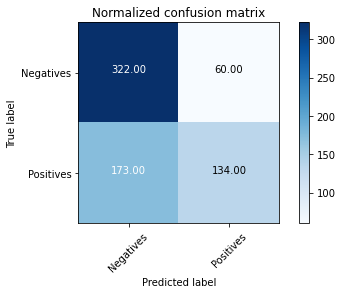

In [604]:
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 2-ой алгоритм

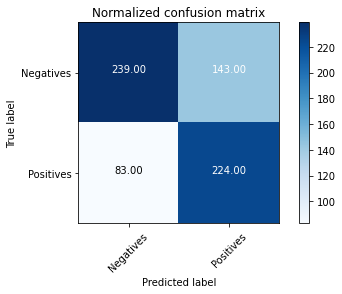

In [605]:
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 3-ий алгоритм

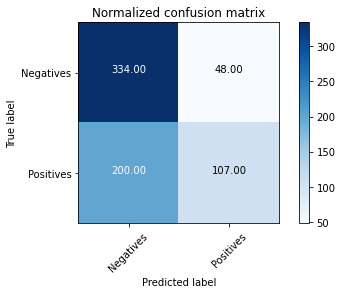

In [606]:
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5.** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [705]:
df.shape

(689, 21)

In [707]:
T_ans_1 = 0
T_ans_2 = 0
T_ans_3 = 0

recall_ans_1 = recall_score(df['target'], df['pred1_classes'])
recall_ans_2 = recall_score(df['target'], df['pred2_classes'])
recall_ans_3 = recall_score(df['target'], df['pred3_classes'])

lol = ["pred1_probs", "pred2_probs", "pred3_probs"]
lol_classes = ["pred1_classes", "pred2_classes", "pred3_classes"]
recall_lol = [recall_ans_1, recall_ans_2, recall_ans_3]
T_ans = [T_ans_1, T_ans_2, T_ans_3]

for j in range(3):
    for T in np.arange(0.1,1,0.01):
        for i in range(689):
            if df[lol[j]][i] >= T:
                df[lol_classes[j]][i] = 1
            else:
                df[lol_classes[j]][i] = 0
        accuracy = accuracy_score(df['target'], df[lol_classes[j]])
        recall = recall_score(df['target'], df[lol_classes[j]])
        if accuracy >= 0.65:
            if recall >= recall_lol[j]:
                T_ans[j] = T
                recall_lol[j] = recall
    print(T_ans[j], recall_lol[j])

0.3599999999999999 0.742671009771987
0.30999999999999994 0.8371335504885994
0 0.1465798045602606


In [708]:
T_ans

[0.3599999999999999, 0.30999999999999994, 0]

**Задание 6.** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

In [715]:
new1 = np.zeros(689)
new2= np.zeros(689)
new3 = np.zeros(689)

new1 = pd.DataFrame(data=new1, columns=["pred1_classes_new"])
new2 = pd.DataFrame(data=new2, columns=["pred2_classes_new"])
new3 = pd.DataFrame(data=new3, columns=["pred3_classes_new"])

df['pred1_classes_new'] = new1['pred1_classes_new'].values
df['pred2_classes_new'] = new2['pred2_classes_new'].values
df['pred3_classes_new'] = new3['pred3_classes_new'].values

In [719]:
df.loc[df.pred1_probs >= T_ans[0], 'pred1_classes_new'] = 1
df.loc[df.pred2_probs >= T_ans[1], 'pred2_classes_new'] = 1
df.loc[df.pred3_probs >= T_ans[2], 'pred3_classes_new'] = 1

In [720]:
df

,0,1,2,3,4,5,6,7,8,9,...,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes,pred1_classes_new,pred2_classes_new,pred3_classes_new
0,1,22.08,11.460,2,4,4,1.585,0,0,0,...,0,0.506772,0,0.610853,0,0.375494,0,1.0,1.0,1.0
1,0,22.67,7.000,2,8,4,0.165,0,0,0,...,0,0.358519,0,0.185941,0,0.200975,0,0.0,0.0,1.0
2,0,29.58,1.750,1,4,4,1.250,0,0,0,...,0,0.358753,0,0.523009,0,0.160465,0,0.0,1.0,1.0
3,0,21.67,11.500,1,5,3,0.000,1,1,11,...,1,0.408729,0,0.185941,0,0.357771,0,1.0,0.0,1.0
4,1,20.17,8.170,2,6,4,1.960,1,1,14,...,1,0.480904,0,0.526646,0,0.260169,0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,1,31.57,10.500,2,14,4,6.500,1,0,0,...,1,0.776376,0,0.804659,0,0.910302,0,1.0,1.0,1.0
685,1,20.67,0.415,2,8,4,0.125,0,0,0,...,0,0.273138,0,0.175782,0,0.139252,0,0.0,0.0,1.0
686,0,18.83,9.540,2,6,4,0.085,1,0,0,...,1,0.383878,0,0.185941,0,0.272625,0,1.0,0.0,1.0
687,0,27.42,14.500,2,14,8,3.085,1,1,1,...,1,0.645865,0,0.804659,0,0.682064,0,1.0,1.0,1.0


In [721]:
cnf_matrix1n = confusion_matrix(df['target'], df['pred1_classes_new'])
cnf_matrix2n = confusion_matrix(df['target'], df['pred2_classes_new'])
cnf_matrix3n = confusion_matrix(df['target'], df['pred3_classes_new'])
np.set_printoptions(precision=2)

### 1-ый алгоритм

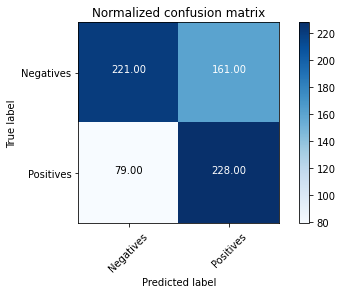

In [722]:
plt.figure()
plot_confusion_matrix(cnf_matrix1n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 2-ой алгоритм

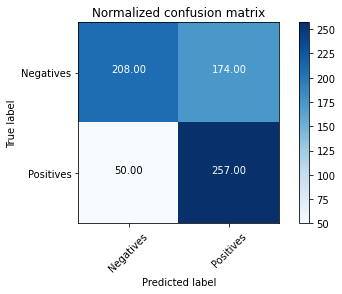

In [723]:
plt.figure()
plot_confusion_matrix(cnf_matrix2n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 3-ий алгоритм

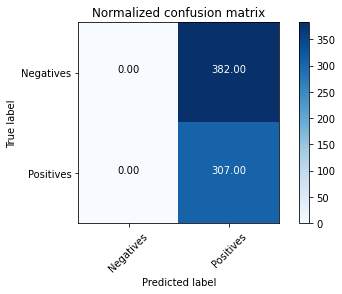

In [724]:
plt.figure()
plot_confusion_matrix(cnf_matrix3n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**Выводы:** здесь напишите, какая модель лучше всего справилась с поставленной задачей.

**Ответ:** Судя по максимальным значениям полноты, лучше всего справилась вторая модель. 

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7.** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [725]:
T_ans_1 = 0
T_ans_2 = 0
T_ans_3 = 0

precision_ans_1 = precision_score(df['target'], df['pred1_classes'])
precision_ans_2 = precision_score(df['target'], df['pred2_classes'])
precision_ans_3 = precision_score(df['target'], df['pred3_classes'])

lol = ["pred1_probs", "pred2_probs", "pred3_probs"]
lol_classes = ["pred1_classes", "pred2_classes", "pred3_classes"]
precision_lol = [precision_ans_1, precision_ans_2, precision_ans_3]
T_ans = [T_ans_1, T_ans_2, T_ans_3]

for j in range(3):
    for T in np.arange(0.1,1,0.01):
        for i in range(689):
            if df[lol[j]][i] >= T:
                df[lol_classes[j]][i] = 1
            else:
                df[lol_classes[j]][i] = 0
        accuracy = accuracy_score(df['target'], df[lol_classes[j]])
        precision = precision_score(df['target'], df[lol_classes[j]])
        if accuracy >= 0.65:
            if precision >= precision_lol[j]:
                T_ans[j] = T
                precision_lol[j] = precision
    print(T_ans[j], precision_lol[j])

0 1.0
0.7499999999999997 0.8367346938775511
0 0.7555555555555555


**Задание 8.** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

In [726]:
new1 = np.zeros(689)
new2= np.zeros(689)
new3 = np.zeros(689)

new1 = pd.DataFrame(data=new1, columns=["pred1_classes_new2"])
new2 = pd.DataFrame(data=new2, columns=["pred2_classes_new2"])
new3 = pd.DataFrame(data=new3, columns=["pred3_classes_new2"])

df['pred1_classes_new2'] = new1['pred1_classes_new2'].values
df['pred2_classes_new2'] = new2['pred2_classes_new2'].values
df['pred3_classes_new2'] = new3['pred3_classes_new2'].values

In [727]:
df.loc[df.pred1_probs >= T_ans[0], 'pred1_classes_new2'] = 1
df.loc[df.pred2_probs >= T_ans[1], 'pred2_classes_new2'] = 1
df.loc[df.pred3_probs >= T_ans[2], 'pred3_classes_new2'] = 1

In [728]:
cnf_matrix1n = confusion_matrix(df['target'], df['pred1_classes_new2'])
cnf_matrix2n = confusion_matrix(df['target'], df['pred2_classes_new2'])
cnf_matrix3n = confusion_matrix(df['target'], df['pred3_classes_new2'])
np.set_printoptions(precision=2)

### 1-ый алгоритм

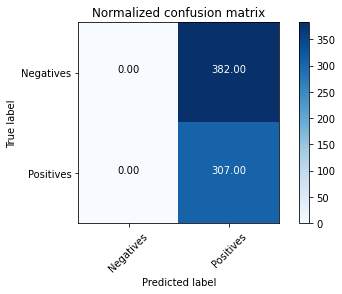

In [729]:
plt.figure()
plot_confusion_matrix(cnf_matrix1n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 2-ой алгоритм

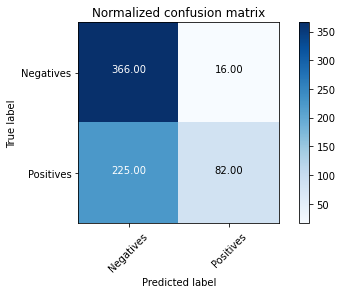

In [730]:
plt.figure()
plot_confusion_matrix(cnf_matrix2n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 3-ий алгоритм

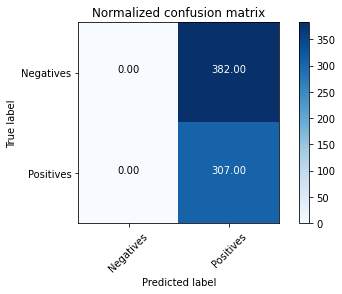

In [731]:
plt.figure()
plot_confusion_matrix(cnf_matrix3n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**Ответ:** Лучше всех справилась первая модель, так как точность максимальна. 

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9.** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [732]:
T_ans_1 = 0
T_ans_2 = 0
T_ans_3 = 0

f1_ans_1 = f1_score(df['target'], df['pred1_classes'])
f1_ans_2 = f1_score(df['target'], df['pred2_classes'])
f1_ans_3 = f1_score(df['target'], df['pred3_classes'])

lol = ["pred1_probs", "pred2_probs", "pred3_probs"]
lol_classes = ["pred1_classes", "pred2_classes", "pred3_classes"]
f1_lol = [f1_ans_1, f1_ans_2, f1_ans_3]
T_ans = [T_ans_1, T_ans_2, T_ans_3]

for j in range(3):
    for T in np.arange(0.1,1,0.01):
        for i in range(689):
            if df[lol[j]][i] >= T:
                df[lol_classes[j]][i] = 1
            else:
                df[lol_classes[j]][i] = 0
        accuracy = accuracy_score(df['target'], df[lol_classes[j]])
        f1 = f1_score(df['target'], df[lol_classes[j]])
        if accuracy >= 0.65:
            if f1 >= f1_lol[j]:
                T_ans[j] = T
                f1_lol[j] = f1
    print(T_ans[j], f1_lol[j])

0.3599999999999999 0.6551724137931035
0.3199999999999999 0.6990291262135923
0 0.19318181818181815


In [733]:
new1 = np.zeros(689)
new2= np.zeros(689)
new3 = np.zeros(689)

new1 = pd.DataFrame(data=new1, columns=["pred1_classes_new3"])
new2 = pd.DataFrame(data=new2, columns=["pred2_classes_new3"])
new3 = pd.DataFrame(data=new3, columns=["pred3_classes_new3"])

df['pred1_classes_new3'] = new1['pred1_classes_new3'].values
df['pred2_classes_new3'] = new2['pred2_classes_new3'].values
df['pred3_classes_new3'] = new3['pred3_classes_new3'].values

In [734]:
df.loc[df.pred1_probs >= T_ans[0], 'pred1_classes_new3'] = 1
df.loc[df.pred2_probs >= T_ans[1], 'pred2_classes_new3'] = 1
df.loc[df.pred3_probs >= T_ans[2], 'pred3_classes_new3'] = 1

In [735]:
cnf_matrix1n = confusion_matrix(df['target'], df['pred1_classes_new3'])
cnf_matrix2n = confusion_matrix(df['target'], df['pred2_classes_new3'])
cnf_matrix3n = confusion_matrix(df['target'], df['pred3_classes_new3'])
np.set_printoptions(precision=2)

### 1-ый алгоритм

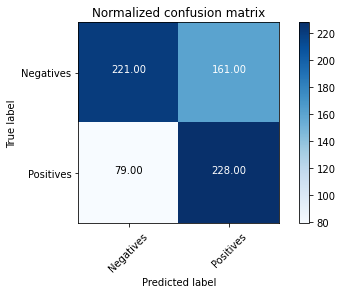

In [736]:
plt.figure()
plot_confusion_matrix(cnf_matrix1n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 2-ой алгоритм

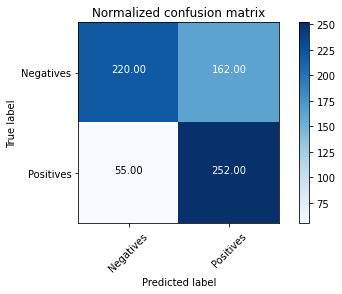

In [737]:
plt.figure()
plot_confusion_matrix(cnf_matrix2n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 3-ий алгоритм

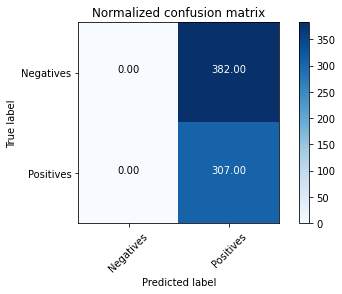

In [738]:
plt.figure()
plot_confusion_matrix(cnf_matrix3n, classes=['Negatives', 'Positives'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**Ответ:** Лучше всех справилась 2 модель, так как у нее самое большое значение f1. 

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [603]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       382
           1       0.69      0.44      0.53       307

    accuracy                           0.66       689
   macro avg       0.67      0.64      0.63       689
weighted avg       0.67      0.66      0.65       689



### Обучим свою модель для предсказания target.

**Задание 10.** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [613]:
Xnew = df[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']]
ynew = df[['target']]

In [614]:
Xnew.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159


In [615]:
ynew.head()

,target
0,0
1,0
2,0
3,1
4,1


In [617]:
cs = CustomScaler(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
Xnew = cs.fit_transform(Xnew)

In [618]:
Xnew

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.689474,-0.800189,1.345702,0.543460,-0.915390,-0.348248,-0.190685,-1.049099,-0.865292,-0.494332,1.089634,0.238010,-0.487079,0.037071
1,-1.450381,-0.750225,0.449679,0.543460,0.170626,-0.348248,-0.615008,-1.049099,-0.865292,-0.494332,-0.917740,0.238010,-0.138406,-0.195561
2,-1.450381,-0.165051,-0.605056,-1.782279,-0.915390,-0.348248,-0.290789,-1.049099,-0.865292,-0.494332,1.089634,0.238010,0.558939,-0.195561
3,-1.450381,-0.834910,1.353739,-1.782279,-0.643886,-0.850220,-0.664313,0.953198,1.155679,1.768074,1.089634,0.238010,-1.068200,-0.195561
4,0.689474,-0.961938,0.684735,0.543460,-0.372382,-0.348248,-0.078628,0.953198,1.155679,2.385094,-0.917740,0.238010,-0.719527,-0.165234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.689474,0.003472,1.152837,0.543460,1.799650,-0.348248,1.278011,0.953198,-0.865292,-0.494332,-0.917740,0.238010,-1.068200,-0.195561
685,0.689474,-0.919595,-0.873260,0.543460,0.170626,-0.348248,-0.626961,-1.049099,-0.865292,-0.494332,-0.917740,0.238010,-1.068200,-0.187115
686,-1.450381,-1.075416,0.959971,0.543460,-0.372382,-0.348248,-0.638914,0.953198,-0.865292,-0.494332,-0.917740,0.238010,-0.487079,-0.195561
687,-1.450381,-0.347971,1.956445,0.543460,1.799650,1.659642,0.257544,0.953198,1.155679,-0.288659,-0.917740,0.238010,-0.370855,-0.193449


In [619]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
params = {'C': np.arange(0.1, 1.1, 0.1)}
grid = GridSearchCV(model, params)

grid.fit(Xnew, ynew)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8650375542155929
best params: {'C': 0.1}


In [620]:
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(Xnew, ynew, test_size=0.3)

In [621]:
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.1)
model.fit(Xtrain3, ytrain3)

pred_train_last = model.predict(Xtrain3)
pred_test_last = model.predict(Xtest3)

f1_score(ytrain3, pred_train_last), f1_score(ytest3, pred_test_last)

(0.8624708624708625, 0.8387096774193549)

**Задание 11.** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [ ]:
#your code here